In [1]:
# Standard imports
import numpy as np
from sklearn.gaussian_process import kernels
from matplotlib import pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [13]:
import gpytorch
import torch
import numpy as np
import matplotlib.pyplot as plt
from gpytorch.kernels import Kernel, MaternKernel

# Function to train the model
def train_model(train_x, train_y, likelihood):
    model = NonStationaryGPModel(train_x, train_y, likelihood, num_points=4)
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    best_loss = float('inf')
    params = None

    print(f"RBF Centers: \n{model.covar_module.rbf_centers.detach().numpy()}")

    for i in range(50):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()

        print(f"Iter {i+1}/50 - Loss: {loss.item():.3f}")
        print(f"Base Kernel Lengthscale: \n{model.covar_module.base_kernel.lengthscale.item()}")
        print(f"RBF Widths: \n{model.covar_module.raw_rbf_widths.detach().numpy()}")
        print(f"Signal Variance: \n{model.covar_module.coefficients.detach().numpy()}")

        if loss.item() < best_loss:
            print('Saving model parameters...')
            best_loss = loss.item()
            params = model.state_dict()

        optimizer.step()

    return model, params

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


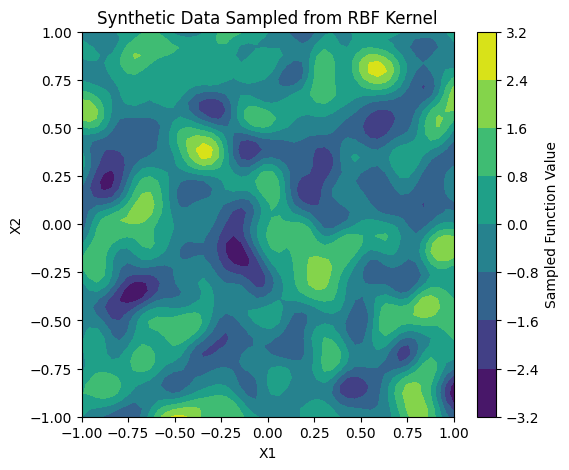

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split

# Generate grid points
x_range = np.linspace(-1, 1, 50)
y_range = np.linspace(-1, 1, 50)
X1, X2 = np.meshgrid(x_range, y_range)
X = np.vstack([X1.ravel(), X2.ravel()]).T  # Flatten the grid for kernel computation

# Define the true RBF kernel
rbf_kernel = RBF(length_scale=0.1)

# Compute the true RBF covariance matrix
K_true = rbf_kernel(X)

# Ensure numerical stability
K_true += 1e-6 * np.eye(K_true.shape[0])

# Generate a sample function from the RBF Gaussian Process
mu = np.zeros(X.shape[0])  # Mean vector
z_true = np.random.multivariate_normal(mu, K_true, 1).reshape(X1.shape)
train_y, _ = train_test_split(z_true.ravel(), train_size=0.4, random_state=42)

# Plot the true function sampled from the RBF GP
plt.figure(figsize=(6, 5))
plt.contourf(X1, X2, z_true, cmap="viridis")
plt.colorbar(label="Sampled Function Value")
plt.title("Synthetic Data Sampled from RBF Kernel")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

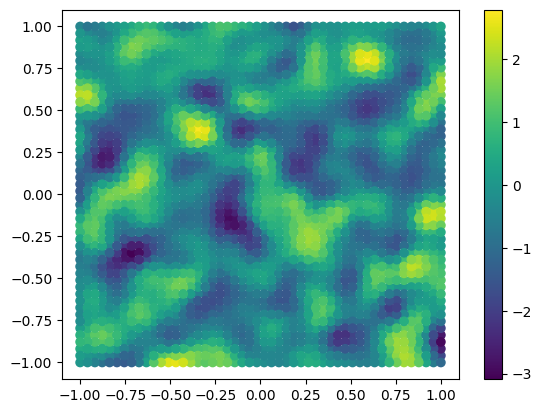

In [40]:
observed_coords = np.random.choice(X.shape[0], 2500, replace=False)
plt.scatter(X[observed_coords, 0], X[observed_coords, 1], c=z_true.flatten()[observed_coords])
plt.colorbar()
plt.show()

In [5]:
cd ..

/Users/edliao/Code/uhi-deep-learning


In [6]:
from src.models import NonStationaryGPModel

In [41]:
import torch
import gpytorch
from gpytorch.kernels import MaternKernel

# Convert training data to PyTorch tensors
train_x = torch.tensor(X[observed_coords], dtype=torch.float32)
train_y = torch.tensor(z_true.ravel()[observed_coords], dtype=torch.float32)

# Define likelihood and GP model
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Train the GP model using your Non-Stationary Kernel
trained_model, _ = train_model(train_x, train_y, likelihood)

RBF Centers: 
[[0.1 0.1]
 [0.1 0.9]
 [0.9 0.1]
 [0.9 0.9]]
Iter 1/50 - Loss: 1.322
Base Kernel Lengthscale: 
0.6931471824645996
RBF Widths: 
[1. 1. 1. 1.]
Signal Variance: 
[-1.2516899   0.6625999   0.67349064 -0.36585   ]
Saving model parameters...
Iter 2/50 - Loss: 1.239
Base Kernel Lengthscale: 
0.6443966627120972
RBF Widths: 
[1.0999999  0.90000004 0.90000004 1.0999999 ]
Signal Variance: 
[-1.3516899   0.56259996  0.5734907  -0.46585   ]
Saving model parameters...
Iter 3/50 - Loss: 1.159
Base Kernel Lengthscale: 
0.598275363445282
RBF Widths: 
[1.1990145 0.8036277 0.802823  1.1991539]
Signal Variance: 
[-1.4489561   0.46573016  0.4767845  -0.56346685]
Saving model parameters...
Iter 4/50 - Loss: 1.079
Base Kernel Lengthscale: 
0.5545894503593445
RBF Widths: 
[1.2974247 0.7108668 0.7089511 1.298187 ]
Signal Variance: 
[-1.5442021   0.37157843  0.38255152 -0.6593203 ]
Saving model parameters...
Iter 5/50 - Loss: 1.010
Base Kernel Lengthscale: 
0.5131420493125916
RBF Widths: 
[1.39446

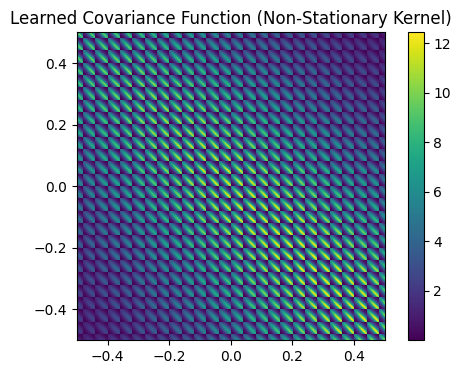

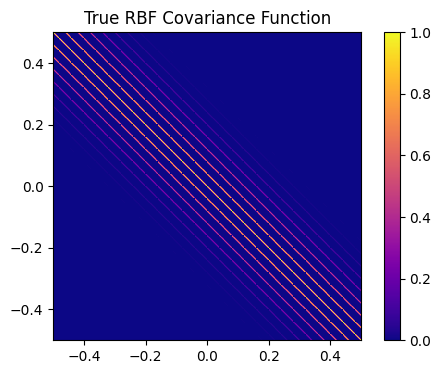

In [43]:
# Compute the learned covariance matrix from the trained model
def compute_learned_covariance(model, test_x):
    model.eval()
    with torch.no_grad():
        cov_matrix = model.covar_module(test_x, test_x).evaluate()
    return cov_matrix

# Generate test points
test_x = torch.tensor(X, dtype=torch.float32)

# Compute the learned covariance matrix
K_learned = compute_learned_covariance(trained_model, test_x)

# Plot the learned covariance function
plt.figure(figsize=(6, 4))
plt.imshow(K_learned.numpy(), cmap="viridis", interpolation="nearest", extent=(-1, 1, -1, 1))
plt.colorbar()
plt.title("Learned Covariance Function (Non-Stationary Kernel)")

# Focus only on a narrow band around the diagonal
zoom_margin = 0.5  # adjust this to zoom more or less
plt.xlim(-zoom_margin, zoom_margin)
plt.ylim(-zoom_margin, zoom_margin)

plt.show()

# Plot the true covariance function
plt.figure(figsize=(6, 4))
plt.imshow(K_true, cmap="plasma", interpolation="nearest", extent=(-1, 1, -1, 1))
plt.colorbar()
plt.title("True RBF Covariance Function")
# Focus only on a narrow band around the diagonal
zoom_margin = 0.5  # adjust this to zoom more or less
plt.xlim(-zoom_margin, zoom_margin)
plt.ylim(-zoom_margin, zoom_margin)
plt.show()

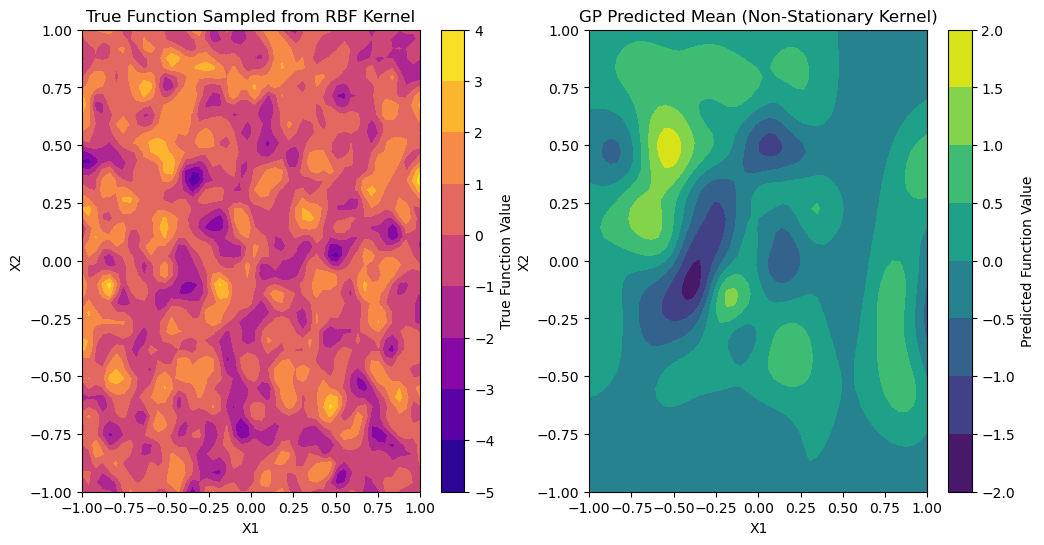

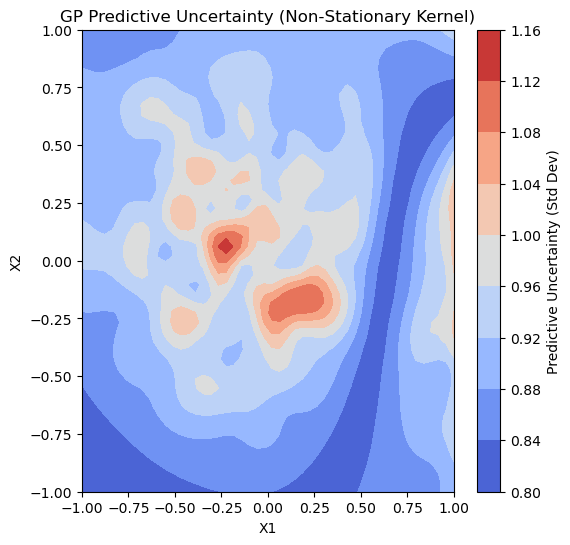

In [22]:
# Function to generate predictions using the trained GP model
def generate_predictions(model, likelihood, test_x):
    model.eval()
    likelihood.eval()

    with torch.no_grad():
        predictive_dist = likelihood(model(test_x))  # GP predictive distribution
        mean_pred = predictive_dist.mean.numpy()

        # Directly extract diagonal variance from covariance matrix
        std_pred = torch.sqrt(predictive_dist.covariance_matrix.diagonal()).numpy()

    return mean_pred, std_pred

# Generate predictions for test points
mean_pred, std_pred = generate_predictions(trained_model, likelihood, test_x)

# Reshape predictions to match the grid
mean_pred_reshaped = mean_pred.reshape(X1.shape)
std_pred_reshaped = std_pred.reshape(X1.shape)

# Plot True Function vs. Predicted Mean
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# True function (from synthetic RBF data)
contour1 = ax[0].contourf(X1, X2, z_true, cmap="plasma")
fig.colorbar(contour1, ax=ax[0], label="True Function Value")  # Corrected

ax[0].set_title("True Function Sampled from RBF Kernel")
ax[0].set_xlabel("X1")
ax[0].set_ylabel("X2")

# GP predicted mean
contour2 = ax[1].contourf(X1, X2, mean_pred_reshaped, cmap="viridis")
fig.colorbar(contour2, ax=ax[1], label="Predicted Function Value")  # Corrected

ax[1].set_title("GP Predicted Mean (Non-Stationary Kernel)")
ax[1].set_xlabel("X1")
ax[1].set_ylabel("X2")

plt.show()

# Plot Standard Deviation (Uncertainty Estimates)
plt.figure(figsize=(6, 6))
contour3 = plt.contourf(X1, X2, std_pred_reshaped, cmap="coolwarm")
plt.colorbar(label="Predictive Uncertainty (Std Dev)")
plt.title("GP Predictive Uncertainty (Non-Stationary Kernel)")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [23]:
from sklearn.metrics import mean_squared_error

# Compute RMSE between true function values and GP predicted mean
rmse = np.sqrt(mean_squared_error(z_true.ravel(), mean_pred))

# Print RMSE
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Root Mean Squared Error (RMSE): 0.9153
